In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import minimize, newton, Bounds
from scipy.stats import norm, lognorm, uniform, randint

# KlassBits Computerized Adaptive Test (CAT) Model

Question item pool with dichotomous items. 

The __Difficulty Level__ will have 5 discrete steps: `[1,2,3,4,5]`. This will be zero-centered in the parameter to `[-2,-1,0,1,2]`.

Label
1. Course (วิชา)
2. Grade (ชั้นเรียน)
3. Chapter (บทเรียน)
4. Lesson/Learning Objective/Section (หัวข้อ/จุดประสงค์ของการเรียนรู้): ไม่มีการซ้ำกันระหว่างบทเรียน  และไม่มี Weight มีความสำคัญเท่ากันหมด

Hence, 1 Student will have the ML estimator ${\hat{\theta}}$ equal to the amount of learning objectives (estimate per learning objective). 

## First Item Selection

Difficulty Level = 2 or 3

Examiner Set Average ก่อน 

Can average per learning objective in the population.


## Termination Criteria

Termination criteria studies in computerized adaptive testing (Babcock and Weiss, 2009) compared a large number of CAT termination criteria using multiple item banks. Four termination rules were examined to determine which termination rules led to best CAT estimation of examinee’s ability: **fixed-length termination**, **standard error termination**, **minimum information termination**, and **$\theta$ convergence**. 

These results indicated that CAT administrators using **standard error termination** should use a standard error that is equal to or smaller than **0.315** for accurate measurement of 𝜃 in terms of bias. Fixed-length termination does not perform as well as variable-length termination with respect to test length and accuracy. 𝜃 convergence performed slightly worse than standard error termination, and minimum information termination administered too many items for large item banks. 
The study suggests using **minimum items constraint** (around **15-20 items**) in combination with a variable termination criteria (**standard error termination** with value **≤ 0.315**).

Babcock, B. & Weiss, D.J. (2009), _Termination criteria in computerized adaptive tests: Variable-length CATs are not biased_.


And we are also using **time constraint**, and *__penalization__ for not completing tests to a certain threshold* (will find from experiment when does normally SE < 0.3).

In [2]:
# The Starting ability level (theta) of the test. 
# This can be either 2 or 3. Somewhere in the middle.
THETA_0 = 2
LEVELS = list(range(-2,3))

# Method parameter for scipy.optimize.minimize
MINIMIZATION_METHOD = 'Nelder-Mead'

### For Monte Carlo Simulation ###
# Number of Questions in the item pool
NUM_QUESTIONS = 500
NUM_STUDENTS = 300

# Item Response Theory (IRT)

Thorough discussion of IRT can be found in Baker and Kim (2004), Bock (1997), and van der Linden and Hambleton (1997).

IRT is an approach to modern educational and psychological measurement which addresses the measurement of a hypothetical latent construct such as ability or attitude. These latent traits cannot be measured directly on individuals and must be quantified via responses to items or questions in a test or survey.


## Two Parameter Logistic (2PL) Model
$$P_i(\theta) = \frac{1}{1+e^{-1.7a_i(\theta-b_i)}}$$

## Three Parameter Logistic (3PL) Model
$$P_i(\theta) = c + (1-c)\frac{1}{1+e^{-1.7a_i(\theta-b_i)}}$$

where $\theta$ is the ability level
$$a \text{ is the discrimination parameter}$$
$$b \text{ is the difficulty parameter}$$
$$c \text{ is the guessing parameter}$$

In [3]:
def two_pl(a, b, t):
    """2PL Implementation (Vectorized). 
    N Students with K Test Items (Should not be the whole item pool!)
    Inputs: 
        a: Discrimination Parameter. Shape of (K,)
        b: Difficulty Parameter. Shape of (K,)
        t: Ability Level (Theta). Shape of (N,)
    Returns:
        Probability matrix of shape (K, N)
    """
    # If t is a matrix, do broadcasting, if not, just make it scalar
    if hasattr(t, '__len__') and (not isinstance(t, str)):
        tt = np.expand_dims(t, axis=1)
    else:
        tt = t
    return 1/(1 + np.exp(-1.7*a*(tt-b)))

Text(0.5, 0, 'Latent Student Trait Level [θ]')

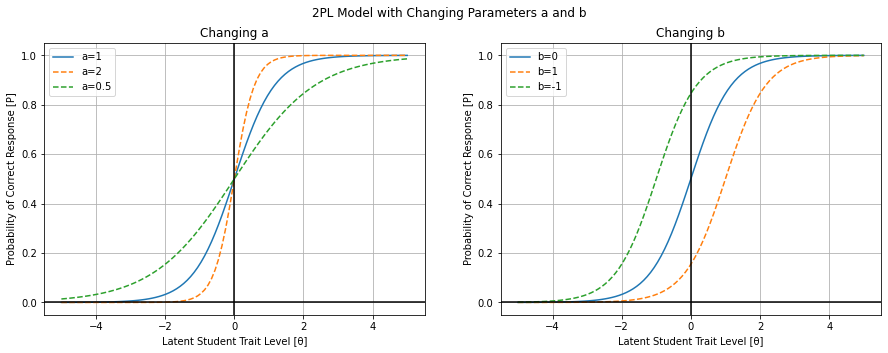

In [4]:
x = np.linspace(-5, 5, 100)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('2PL Model with Changing Parameters a and b')
ax1.plot(x, two_pl(1,0,x), '-', label='a=1')
ax1.plot(x, two_pl(2,0,x), '--', label='a=2')
ax1.plot(x, two_pl(0.5,0,x), '--', label='a=0.5')
ax1.grid(True)
ax1.axhline(y=0, color='k')
ax1.axvline(x=0, color='k')
ax1.legend()
ax1.set_title('Changing a')
ax1.set_ylabel('Probability of Correct Response [P]')
ax1.set_xlabel('Latent Student Trait Level [θ]')

ax2.plot(x, two_pl(1,0,x), '-', label='b=0')
ax2.plot(x, two_pl(1,1,x), '--', label='b=1')
ax2.plot(x, two_pl(1,-1,x), '--', label='b=-1')
ax2.grid(True)
ax2.axhline(y=0, color='k')
ax2.axvline(x=0, color='k')
ax2.legend()
ax2.set_title('Changing b')
ax2.set_ylabel('Probability of Correct Response [P]')
ax2.set_xlabel('Latent Student Trait Level [θ]')

If the response pattern is locally independent (the test question of before does not affect the next question), the conditional probability of a single problem where an examinee with ability $\theta$ obtains a response on item $i$ is denoted by $P_i(u_i|\theta)$. With $u_i$ being a binomial variable of $u_i = 1$ for a correct response and $u_i=0$ for an incorrect response, we get:

\begin{align}
P(u_i|\theta) &= P_i(\theta)^{u_i}(1-P_i(\theta))^{1-u_i} \\
              &= P_i(\theta)^{u_i}Q_i(\theta)^{1-u_i}
\end{align}

Thus, the joint probability of an observed response pattern with $n$ items can be denoted by the likelihood function:

\begin{align}
 P(u_1,u_2,...,u_n|\theta) &= P(u_1|\theta)P(u_2|\theta) ... P(u_n|\theta) \\
                           &= \prod_{i=1}^n P_i(\theta)^{u_i} Q_i(\theta)^{1-u_i}
\end{align}

The log-likelihood function yields:

\begin{align}
 l(\theta) = \ln P(u_1,u_2,...,u_n|\theta) &= \ln \prod_{i=1}^n P_i(\theta)^{u_i} Q_i(\theta)^{1-u_i} \\
                           &= \sum_{i=1}^n \big[ u_i \ln P_i(\theta) + (1-u_i) \ln  Q_i(\theta)  \big]
\end{align}

The estimate $\hat{\theta}$ is defined as the value that maximizes the likelihood (and consequently the log-likelihood).

\begin{align}
\hat{\theta} = \underset{\theta}{\operatorname{argmax}} l(\theta)
\end{align}

In [5]:
def get_log_likelihood_f(a, b, u, minimization=True):
    """For a single student with latent trait theta.
    Note: May calculate the two_pl again, but I think it's worth it as a modular function
    Input:
        a: Discrimination Parameter. Shape of (K,)  Questions
        b: Difficulty Parameter. Shape of (K,) Questions
        u: vector correct u_i=1 correct, u_i=0 wrong. Shape of (K,) Reponses
        minimization: minimization problem or maximization problem
    Result:
        Function of log-likelihood suitable for optimization. with Input 
            theta: Latent trait theta. Shape of [1] ?
    """
    is_minimize = -1 if minimization else 1
    def log_likelihood(theta):
        p = np.squeeze(two_pl(a, b, theta)) # Returns shape of [K,1] -> [K,]
        return np.sum(u*np.log(p) + (1-u)*np.log(1-p))*is_minimize
    return log_likelihood

In [6]:
_a = np.ones(10)
_b = np.array(range(10))
_u = np.array([0, 0, 1, 1, 0, 0, 0, 1, 1, 0])
_p = np.squeeze(two_pl(_a, _b, [2]))

print(_u)
print(np.log(_p))
print(np.log(1-_p))
print(-np.sum(_u*np.log(_p) + (1-_u)*np.log(1-_p)))
get_log_likelihood_f(_a, _b, _u)([2])

[0 0 1 1 0 0 0 1 1 0]
[ -0.03282847  -0.16778603  -0.69314718  -1.86778603  -3.43282847
  -5.10607824  -6.80111316  -8.50020345 -10.20003717 -11.90000679]
[-3.43282847e+00 -1.86778603e+00 -6.93147181e-01 -1.67786029e-01
 -3.28284704e-02 -6.07823660e-03 -1.11315536e-03 -2.03447672e-04
 -3.71696279e-05 -6.79038175e-06]
26.601814979826216


26.601814979826216

# Monte Carlo Simulation

As IRT provides an estimation of the probability of a correct response to each question for a given value of examinee ability, a response with **2PL distribution** is generated for each question by using the question parameters and the examinee ability to calculate the probability of correct response. 

In [7]:
class QuestionParametersDistribution(object):
    """
    An object for generation Item Pool parameters.
    Will Generate a and b. With shape (2, ...size)
    Fix a will fix A = 1.
    B will be discrete random variable of uniform distribution with difficulty -2, -1, 0, 1, 2 (Corresponding to Level 1-5)
    """
    def __init__(self, a_scale=1, b_low=-2, b_high=2, fix_a=True):
        self.a = randint(1, 2) if fix_a else lognorm(s=1., scale=a_scale)
        self.b = randint(b_low, b_high+1) # High is exclusive
        
    def rvs(self, size=None, random_state=12):
        a = self.a.rvs(size, random_state=random_state)
        b = self.b.rvs(size, random_state=random_state)
        return [a,b]
    
    def pdf(self, *args):
        a = self.a.pdf(*args)
        b = self.b.pdf(*args)
        return np.stack((a,b))

In [8]:
question_dist = QuestionParametersDistribution()
questions = question_dist.rvs(NUM_QUESTIONS)
[question.shape for question in questions]

[(500,), (500,)]

Text(0.5, 0, 'b')

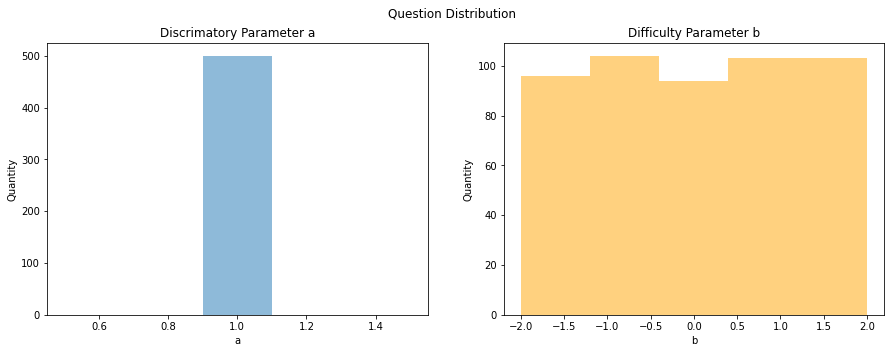

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Question Distribution')

ax1.hist(questions[0], bins=5, histtype='stepfilled', alpha=0.5)
ax1.set_title('Discrimatory Parameter a')
ax1.set_ylabel('Quantity')
ax1.set_xlabel('a')

ax2.hist(questions[1], bins=5, histtype='stepfilled', alpha=0.5, color='orange')
ax2.set_title('Difficulty Parameter b')
ax2.set_ylabel('Quantity')
ax2.set_xlabel('b')

In [10]:
class StudentParametersDistribution(object):
    """
    An object for generation and calculation of student parameters.
    In our context, we will uniformly generate Student Levels at -4 to +4  (+/- 2 out of range of the parameters)
    """
    def __init__(self, theta_low=-4, theta_high=4):
        self.theta = uniform(theta_low, theta_high-theta_low)

    def rvs(self, size=None, random_state=12, *args):
        return self.theta.rvs(size, random_state=random_state, *args)

    def logpdf(self, *args):
        return self.theta.logpdf(*args)

In [11]:
student_dist = StudentParametersDistribution()
students = student_dist.rvs(NUM_STUDENTS)
students.shape

(300,)

Text(0.5, 0, 'Latent Student Trait Level [θ]')

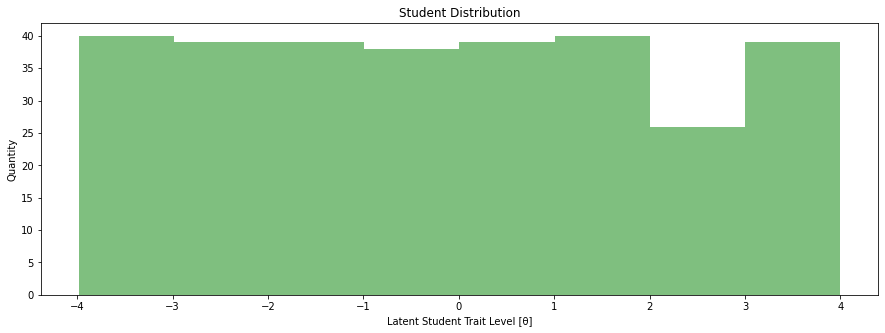

In [12]:
fig, ax = plt.subplots(1, figsize=(15,5))

ax.hist(students, bins=8, histtype='stepfilled', alpha=0.5, color='green')
ax.set_title('Student Distribution')
ax.set_ylabel('Quantity')
ax.set_xlabel('Latent Student Trait Level [θ]')

In [13]:
a,b = questions
theta = students

# Returns shape of [K,N]  (Students,Questions)
probability_matrix = two_pl(a,b,theta)
# Make Binomial Sampling with n=1 trial and p=probability matrix
answers = np.random.binomial(1, probability_matrix)
answers.shape # Will have shape of (Students, Questions)

(300, 500)

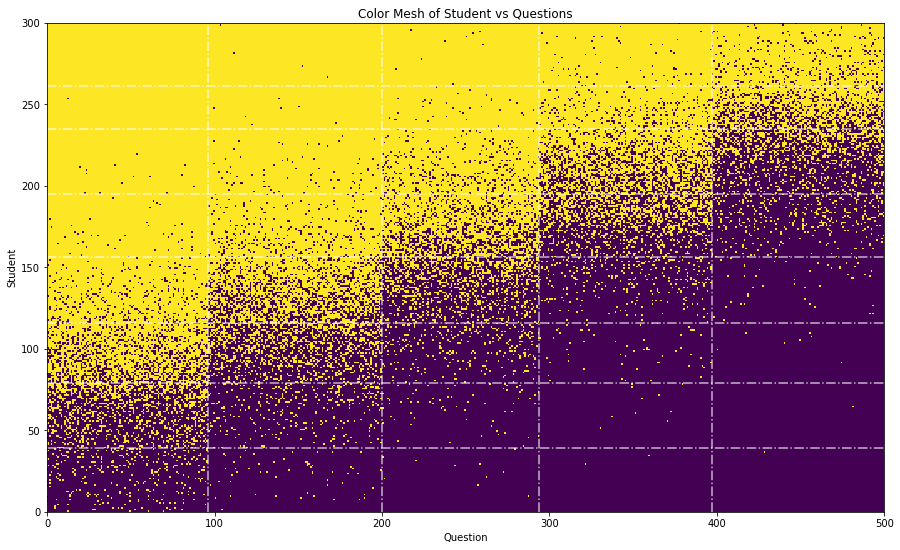

In [14]:
FIG_SIZE_MAX = 15
SCALE_MAX = max(answers.shape)
fig, ax = plt.subplots(1, figsize=(FIG_SIZE_MAX*answers.shape[1]/SCALE_MAX,FIG_SIZE_MAX*answers.shape[0]/SCALE_MAX))

# Sort by question difficulty and student ability
answer_plot = answers
answer_plot = answers[np.argsort(theta), ...]
answer_plot = answer_plot[..., np.argsort(b)]

ax.pcolormesh(answer_plot, cmap='viridis')
ax.set_title('Color Mesh of Student vs Questions')
ax.set_ylabel('Student')
ax.set_xlabel('Question')

# Draw Section lines for question difficulty 
for level in LEVELS:
    b_sorted = np.sort(b)
    question_index = min(np.where(b_sorted == level)[0]) # np.where returns both row and column indices
    ax.axvline(question_index, linestyle='-.', color='white', alpha=0.7)

# Draw Section lines for student ability 
for level in range(-3, 4):
    theta_sorted = np.sort(theta)
    student_index = min(np.where(theta_sorted >= level)[0])
    ax.axhline(student_index, linestyle='-.', color='white', alpha=0.7)

### Optimize Result

```typescript
{
    x:                "The solution of the optimization",
    success:          "Whether or not the optimizer exited successfully.",
    nit:              "Number of iterations performed by the optimizer.",
    nfev, njev, nhev: "Number of evaluations of the objective functions and of its Jacobian and Hessian.",
    fun, jac, hess:   "Values of objective function, its Jacobian and its Hessian (if available)."
}
```

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.OptimizeResult.html#scipy.optimize.OptimizeResult

In [15]:
initial_theta = 2

to_minimize = get_log_likelihood_f(a, b, answers[0])
res = minimize(to_minimize, [initial_theta], method=MINIMIZATION_METHOD)
res

 final_simplex: (array([[-2.58339844],
       [-2.58330078]]), array([84.15673437, 84.15673442]))
           fun: 84.15673437406599
       message: 'Optimization terminated successfully.'
          nfev: 40
           nit: 20
        status: 0
       success: True
             x: array([-2.58339844])

In [16]:
%%time

initial_theta = 2
K = NUM_STUDENTS

res_list = np.zeros((K))
for u_index in range(answers.shape[0]):    
    to_minimize = get_log_likelihood_f(a, b, answers[u_index])
    res = minimize(to_minimize, [initial_theta], method=MINIMIZATION_METHOD)
    res_list[u_index] = res.x

CPU times: user 2.11 s, sys: 0 ns, total: 2.11 s
Wall time: 2.14 s


In [17]:
abs_e = np.abs(res_list - theta)
mae = np.mean(abs_e)
mae_std = np.std(abs_e)

print(f"Mean Absolute Error:\t{mae:.05f} ± {mae_std:.05f}")

print("MAE Per Category")
# Draw Section lines for student ability 
for level in range(-4, 4):
    _abs_e = abs_e[(theta >= level) & (theta <= level+1)]
    _mae = np.mean(_abs_e)
    _mae_std = np.std(_abs_e)
    print(f"θ [{level}, {level+1}]:\t{_mae:.05f} ± {_mae_std:.05f}")

Mean Absolute Error:	0.10600 ± 0.12516
MAE Per Category
θ [-4, -3]:	0.21254 ± 0.21955
θ [-3, -2]:	0.09020 ± 0.06652
θ [-2, -1]:	0.06218 ± 0.05047
θ [-1, 0]:	0.06457 ± 0.04151
θ [0, 1]:	0.06363 ± 0.04951
θ [1, 2]:	0.07447 ± 0.04227
θ [2, 3]:	0.07792 ± 0.05132
θ [3, 4]:	0.19316 ± 0.17724


# Fisher Information

The estimator $\hat{\theta}$ is asymptotically normally distributed with mean $\theta$ and sample variance 

\begin{align}
S^2_{\hat{\theta}} = Var(\hat{\theta}|\theta) &= \left[ -E \frac{\partial^2}{\partial\theta^2} l(\theta) \right]^{-1} \\
&= \left[ -E \frac{\partial^2}{\partial\theta^2} \sum_{i=1}^n \big[ u_i \ln P_i(\theta) + (1-u_i) \ln  Q_i(\theta)  \big] \right]^{-1} \\
\end{align}

1. Finding $\frac{\partial}{\partial\theta} l(\theta)$ and with $P = 1-Q; Q'=-P'$

\begin{align}
\frac{\partial}{\partial\theta} l(\theta) &= \frac{\partial}{\partial\theta} \sum_{i=1}^n \left[ u_i \frac{\partial}{\partial\theta} \ln P_i(\theta) + (1-u_i) \ln   \frac{\partial}{\partial\theta} Q_i(\theta)  \right] \\
&= \sum_{i=1}^n \left[ u_i \frac{\partial}{\partial\theta} \ln P_i(\theta) + (1-u_i) \frac{\partial}{\partial\theta} \ln   Q_i(\theta)  \right]  \\
&=  \sum_{i=1}^n \left[ u_i \frac{P'_i(\theta)}{P_i(\theta)} + (1-u_i)  \frac{Q'_i(\theta)}{Q_i(\theta)}   \right] \\
&=  \sum_{i=1}^n  \frac{ u_i P'_i(\theta) Q_i(\theta) + (1-u_i) P_i(\theta) Q'_i(\theta) }{Q_i(\theta) P_i(\theta)} \\
&=  \sum_{i=1}^n  \frac{ u_i P'_i(\theta) (1-P'_i(\theta)) - (1-u_i) P_i(\theta) P'_i(\theta) }{Q_i(\theta) P_i(\theta)} \\
&=  \boxed{ \sum_{i=1}^n  \frac{ (u_i - P_i(\theta)) P'_i(\theta) }{Q_i(\theta) P_i(\theta)} }
\end{align}



1.1 Finding $P'_i(\theta)$ and $Q'_i(\theta)$

\begin{align}
\frac{\partial}{\partial\theta} P_i(\theta) &= \frac{\partial}{\partial\theta} \frac{1}{1+e^{-1.7a_i(\theta-b_i)}} \\
&=  - \left[ 1+e^{-1.7a_i(\theta-b_i)} \right]^{-2} [e^{-1.7a_i(\theta-b_i)}] [-1.7a] \\
&=  \frac{1.7 a e^{-1.7a_i(\theta-b_i)} }{ (1+e^{-1.7a_i(\theta-b_i)})^2 } = \boxed{ 1.7a P_i(\theta) Q_i(\theta) }
\end{align}

\begin{align}
\frac{\partial}{\partial\theta} Q_i(\theta) &= \frac{\partial}{\partial\theta} \left[ 1 -  P_i(\theta) \right] \\
&= \boxed{ - 1.7a P_i(\theta) Q_i(\theta)}
\end{align}

Continue 1.

\begin{align}
\frac{\partial}{\partial\theta} l(\theta) &=  \sum_{i=1}^n  \frac{ (u_i - P_i(\theta)) 1.7a P_i(\theta) Q_i(\theta) }{Q_i(\theta) P_i(\theta)} \\
&=  \boxed{ \sum_{i=1}^n   1.7a (u_i - P_i(\theta)) } \\
\end{align}

2. Finding  $\frac{\partial^2}{\partial\theta^2} l(\theta)$

\begin{align}
\frac{\partial^2}{\partial\theta^2} l(\theta) &=  \frac{\partial}{\partial\theta} \sum_{i=1}^n   1.7a (u_i - P_i(\theta)) \\
&= \frac{\partial}{\partial\theta} \sum_{i=1}^n   1.7a u_i - \frac{\partial}{\partial\theta} \sum_{i=1}^n 1.7a P_i(\theta)  \\
&= \boxed{ - \sum_{i=1}^n 1.7^2 a^2 P_i(\theta) Q_i(\theta) }
\end{align}


### Information Function

\begin{align}
S^2_{\hat{\theta}} = Var(\hat{\theta}|\theta) &= \left[ -E \frac{\partial^2}{\partial\theta^2} l(\theta) \right]^{-1} \\
&= 1/ \sum_{i=1}^n I_i(\theta)
\end{align}

\begin{align}
I_i(\theta) &= \frac{[P'_i(\theta)]^2}{ P_i(\theta) Q_i(\theta) }  \\
&= \boxed{1.7^2 a^2 P_i(\theta) Q_i(\theta)}
\end{align}

### Standard Error

The standard error will derive directly from the sample variance of $\hat{\theta}$

\begin{align}
SE_{\hat{\theta}} = \sqrt{ S^2_{\hat{\theta}}} &= \sqrt{ \frac{1}{\sum_{i=1}^n I_i(\theta)} }  = \boxed{ \sqrt{ \frac{1}{\sum_{i=1}^n 1.7^2 a^2 P_i(\theta) Q_i(\theta)}  } }
\end{align}

### Problem: การตอบผิดหมด หรือ ถูกหมดทำให้ Model ไม่ converge
มีอยู่สองวิธีทำครับ 
1) แก้ไขวิธีการคำนวณ Standard Error
2) Hard Code Conditional Statement ในโปรแกรม

#1 แก้ไขวิธีการคำนวณ Standard Error
ตอนนี้ SE คำนวณโดย Square Inverse ของ Fisher Information ตามที่เรียนไว้ข้างบน  ถ้าให้ผมเสนอเราอาจจะเพิ่ม Penalty ข้างใน Square Inverse ไปเป็นเช่น  A[min(0, 2-t)^2 + min(0, 2+t)^2]. อันแรกคือจะทำงานต่อเมื่อ t > 2, อันที่สองจะทำงานต่อเมื่อ t < -2 . A เป็น Constant ที่เราปรับได้  และ Square เพราะเราอยากที่จะ Penalty ถ้าเกิดว่าคะแนนเริ่มห่างจาก 2 หรือ -2 [L0, L5] มากขึ้นเรื่อยๆ. ถ้าไม่เร็วพอก็สามารถเปลี่ยน A ให้มัน Penalize เร็วกว่านี้ได้ครับ.

#2 Hard Code Conditional Statement ในโปรแกรม
Conditional Statement นี้เป็นได้หลายแบบครับ  เช่นจะบอกว่าถ้าเกิดว่าตอบผิดหมด  หรือตอบถูกหมด ให้จบ   หรือที่ดีกว่านั้นคือดู Latent Trait Level Estimate จาก Student ครับ   ถ้าเกิน Threshold ที่เรากำหนดไว้ ก็ให้หยุดครับ  เช่นถ้าทดสอบแล้วได้ -3 หรือ +3 ก็ให้ หยุด  อะไรแบบนี้ครับ

### Standard Error (Modified)

Addition of the term of regularizing (penalizing) the outboundaries that occur in the range of  $\theta \in [-2, 2]$. With the addition of the term $/(1+\gamma)$ where $\gamma \in (0, \infty ]$.

The regularizer term $\gamma$ will be $\gamma = A [\min(0, 2-\theta)^2 + \min(0,2+\theta)^2 ] $ , and $A$ is a constant term where $A \in [0, \infty ]$. The first term will penalize iff $\theta > 2$ and the second term will penalize iff $\theta < -2$.

\begin{align}
SE_{\hat{\theta}} = \frac{\sqrt{ S^2_{\hat{\theta}}}}{1+\gamma} &= \frac{1}{1+\gamma} \sqrt{  \frac{1}{\sum_{i=1}^n I_i(\theta)} }  \\
&= \boxed{ \frac{1}{1+A [\min(0, 2-\theta)^2 + \min(0,2+\theta)^2 ]} \sqrt{ \frac{1}{\sum_{i=1}^n 1.7^2 a^2 P_i(\theta) Q_i(\theta)}  } }
\end{align}

### Fisher Scoring Algorithm 

The ML estimate $\hat{\theta}$ is calculated with the Fisher Scoring Algorithm with the Fisher Information calculated. Which, by my observation, is equivalent to the Newton-Raphson algoirthm (with f'/f'') since the Hessian/2nd partial derivative is equivalent to the Fisher Information function (can someone please confirm this? I have not seen text saying these are the same thing). Estimates of the ability parameter is obtained in the following iterative procedure:

\begin{align}
\hat{\theta}_{t+1} &= \hat{\theta}_{t} - \left[ \frac{\partial^2 l(\theta)}{\partial \theta^2} \right]_t^{-1} \left[ \frac{\partial l(\theta)}{\partial \theta} \right]_t \\
&= \hat{\theta}_{t} - \left[ I(\theta) \right]_t^{-1} \left[ \frac{\partial l(\theta)}{\partial \theta} \right]_t \\
&= \boxed{ \hat{\theta}_{t} - \left[  \frac{\sum_{i=1}^n  1.7a (u_i - P_i(\theta)) }{ - \sum_{i=1}^n 1.7^2 a^2 P_i(\theta) Q_i(\theta)} \right] }
\end{align}

The calculation is carried out until the ability score does not change in the last round as of the previous round or convergent. The convergent criterion is 0.05 or 0.01, or even less such as 0.001. 

In [18]:
def fisher_information(a, b, t):
    p = np.squeeze(two_pl(a, b, t)) # Returns shape of [K,1] -> [K,]
    return 1.7**2 * np.square(a) * p * (1-p)

Text(0.5, 0, 'Latent Student Trait Level [θ]')

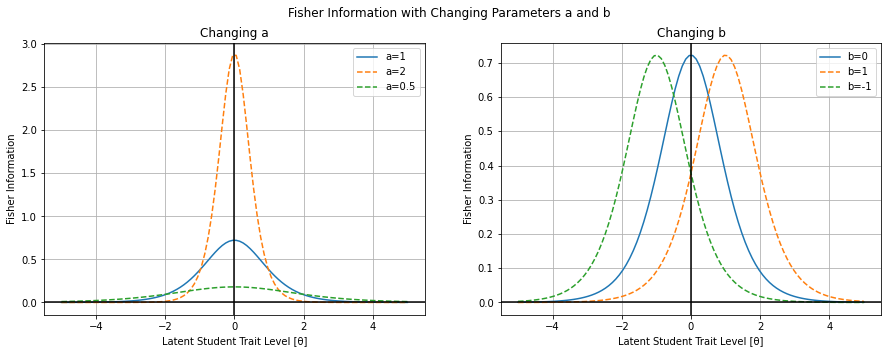

In [19]:
x = np.linspace(-5, 5, 100)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Fisher Information with Changing Parameters a and b')
ax1.plot(x, fisher_information(1,0,x), '-', label='a=1')
ax1.plot(x, fisher_information(2,0,x), '--', label='a=2')
ax1.plot(x, fisher_information(0.5,0,x), '--', label='a=0.5')
ax1.grid(True)
ax1.axhline(y=0, color='k')
ax1.axvline(x=0, color='k')
ax1.legend()
ax1.set_title('Changing a')
ax1.set_ylabel('Fisher Information')
ax1.set_xlabel('Latent Student Trait Level [θ]')

ax2.plot(x, fisher_information(1,0,x), '-', label='b=0')
ax2.plot(x, fisher_information(1,1,x), '--', label='b=1')
ax2.plot(x, fisher_information(1,-1,x), '--', label='b=-1')
ax2.grid(True)
ax2.axhline(y=0, color='k')
ax2.axvline(x=0, color='k')
ax2.legend()
ax2.set_title('Changing b')
ax2.set_ylabel('Fisher Information')
ax2.set_xlabel('Latent Student Trait Level [θ]')

In [20]:
def get_d_log_likelihood_f(a, b, u):
    """For a single student with latent trait theta.
    Input:
        a: Discrimination Parameter. Shape of (K,)  Questions
        b: Difficulty Parameter. Shape of (K,) Questions
        u: vector correct u_i=1 correct, u_i=0 wrong. Shape of (K,) Reponses
    Result:
        Function of first derivative of log-likelihood suitable for optimization. with Input 
            theta: Latent trait theta. Shape of [1] ?
    """
    def d_log_likelihood(theta):
        p = np.squeeze(two_pl(a, b, theta)) # Returns shape of [K,1] -> [K,]
        return np.sum(1.7*a*(u-p))
    return d_log_likelihood

In [21]:
def get_dd_log_likelihood_f(a, b, u):
    """For a single student with latent trait theta.
    Input:
        a: Discrimination Parameter. Shape of (K,)  Questions
        b: Difficulty Parameter. Shape of (K,) Questions
        u: vector correct u_i=1 correct, u_i=0 wrong. Shape of (K,) Reponses
    Result:
        Function of second derivative of log-likelihood suitable for optimization. with Input 
            theta: Latent trait theta. Shape of [1] ?
    """
    def dd_log_likelihood(theta):  #This is just fisher_information with a negative sign!
        p = np.squeeze(two_pl(a, b, theta)) # Returns shape of [K,1] -> [K,]
        return - np.sum(1.7**2 * np.square(a) * p * (1-p))
    return dd_log_likelihood

In [22]:
initial_theta = 2

df = get_d_log_likelihood_f(a, b, answers[0])
ddf = get_dd_log_likelihood_f(a, b, answers[0])
res = newton(df, initial_theta, fprime=ddf, full_output=True, tol=1e-03)
res

(-2.583355097290023,
       converged: True
            flag: 'converged'
  function_calls: 12
      iterations: 6
            root: -2.583355097290023)

In [23]:
%%time

initial_theta = 2
K = NUM_STUDENTS

res_list = np.zeros((K))
for u_index in range(answers.shape[0]):    
    df = get_d_log_likelihood_f(a, b, answers[u_index])
    ddf = get_dd_log_likelihood_f(a, b, answers[u_index])
    res = newton(df, initial_theta, fprime=ddf, full_output=True, tol=1e-03)
    res_list[u_index] = res[0]

CPU times: user 360 ms, sys: 408 µs, total: 361 ms
Wall time: 355 ms


In [24]:
abs_e = np.abs(res_list - theta)
mae = np.mean(abs_e)
mae_std = np.std(abs_e)

print(f"Mean Absolute Error:\t{mae:.05f} ± {mae_std:.05f}")

print("MAE Per Category")
# Draw Section lines for student ability 
for level in range(-4, 4):
    _abs_e = abs_e[(theta >= level) & (theta <= level+1)]
    _mae = np.mean(_abs_e)
    _mae_std = np.std(_abs_e)
    print(f"θ [{level}, {level+1}]:\t{_mae:.05f} ± {_mae_std:.05f}")

Mean Absolute Error:	0.10600 ± 0.12516
MAE Per Category
θ [-4, -3]:	0.21254 ± 0.21955
θ [-3, -2]:	0.09020 ± 0.06652
θ [-2, -1]:	0.06218 ± 0.05047
θ [-1, 0]:	0.06456 ± 0.04151
θ [0, 1]:	0.06362 ± 0.04952
θ [1, 2]:	0.07447 ± 0.04226
θ [2, 3]:	0.07793 ± 0.05132
θ [3, 4]:	0.19316 ± 0.17724


# Results with Monte Carlo Simulation 

Although this assumes that all the students take the same questions and ALL of the questions (which may not be true in the usual case). But I am just testing out whether MLE algorithms work or not. Results are almost equivalent between either Nelder-Mead and Newton-Rhapson (Newton-Rhapson being much faster 0.4s vs 2.3s; number of iterations 6 vs 20). 

### Questions N = 500 , Students  K=300  

|   θ MLE  | Nelder-Mead [MAE] | Newton-Rhapson [MAE] |
|:--------:|:-----------------:|----------------------|
| [-4, -3] | 0.17506 ± 0.14548 |   0.17506 ± 0.14548  |
| [-3, -2] | 0.08980 ± 0.05979 |   0.08980 ± 0.05979  |
| [-2, -1] | 0.06181 ± 0.04397 |   0.06180 ± 0.04396  |
|  [-1, 0] | 0.05734 ± 0.04619 |   0.05734 ± 0.04619  |
|  [0, 1]  | 0.05968 ± 0.04454 |   0.05968 ± 0.04455  |
|  [1, 2]  | 0.06001 ± 0.04784 |   0.06000 ± 0.04784  |
|  [2, 3]  | 0.09983 ± 0.07571 |   0.09983 ± 0.07570  |
|  [3, 4]  | 0.21056 ± 0.22798 |   0.21056 ± 0.22798  |
|   Total  | 0.10178 ± 0.12144 |   0.10178 ± 0.12144  |

More results can be experimented with, but this is not the main purpose of the experiment. We will now proceed with the Computerized Adaptive Testing (CAT) Algorithm. 

# Computerized Adaptive Testing (CAT) Algorithm

1. Obtain a provisional trait estimate $\hat{\theta}_i$ based on the first $i$ responses.
2. Query all relevant items in that วิชา-ชั้นปี-บทเรียน-หัวข้อ, sorted by $|\hat{\theta}-b_i|$ _(unless a constant, this will not work! Because a related question of high discriminating value may have more information.)_ Or just Query all relevant items until done. Calculate information $I_i(\hat{\theta})$ of all items. Select highest information value, and if there are many just randomly pick one. 
3. Administer item and record response.
4. Repeat steps 1 - 3 until min_questions >= 15 and SE <= 0.3
5. Return final trait estimate $\hat{\theta}_i$ 

In [25]:
t = 2
q_count = 0
MIN_Q_COUNT = 15
std_err = 100
Q_START = 5 # The number of questions before starting optimize more than 2 iter (somehow 1 iter doesn't change at all!)
SEED = 12345 # 12345 doesn't converge, 123 converges!!
rng = np.random.default_rng(SEED)

a_list = np.array([])
b_list = np.array([])
u_list = np.array([])

print(f"Actual Student Latent Trait: {theta[0]}")
while not (q_count >= MIN_Q_COUNT and std_err <= 0.3):
    print(f"Question No: {q_count+1}")
    # All of the information in all the items
    items_info = fisher_information(a,b,t)
    # Find the indexes of the items with maximum information (have only 1 axis so [0])
    item_max_info_indexes = np.where(items_info==np.max(items_info))[0]
    # Select a random item from the max indexes
    item_index = rng.choice(item_max_info_indexes)

    # The question is a,b at item_index
    a_list = np.append(a_list, a[item_index])
    b_list = np.append(b_list, b[item_index])
    # Make Binomial Sampling with n=1 trial and p=probability matrix
    p = two_pl(a[item_index],b[item_index],theta[0])
    answer = rng.binomial(1, p)
    u_list = np.append(u_list, answer)
    
    to_minimize = get_log_likelihood_f(a_list, b_list, u_list)
    res = minimize(to_minimize, t, method=MINIMIZATION_METHOD, tol=1e-03, options={ "maxiter": max(q_count - Q_START, 2)})
    std_err = np.sqrt(1/np.sum(fisher_information(a_list,b_list,t)))
    t = res.x # Nelder Mead doesn't work well with bounds!!! 

    print(f"\tConverge: {res.success}")
    print(f"\tIterations: {res.nit}")
    print(f"\ttheta: {res.x}")
    print(f"\tStandard Error: {std_err}")
    q_count += 1
print(f"Actual Student Latent Trait: {theta[0]}")
print(f"MAE {np.abs(t - theta[0])}")

Actual Student Latent Trait: -2.766697260962621
Question No: 1
	Converge: False
	Iterations: 2
	theta: [1.8]
	Standard Error: 1.1764705882352942
Question No: 2
	Converge: False
	Iterations: 2
	theta: [1.62]
	Standard Error: 0.84394012412103
Question No: 3
	Converge: False
	Iterations: 2
	theta: [1.458]
	Standard Error: 0.714976718748962
Question No: 4
	Converge: False
	Iterations: 2
	theta: [1.3122]
	Standard Error: 0.6470231667236274
Question No: 5
	Converge: False
	Iterations: 2
	theta: [1.18098]
	Standard Error: 0.5856483188270836
Question No: 6
	Converge: False
	Iterations: 2
	theta: [1.062882]
	Standard Error: 0.5345851390221286
Question No: 7
	Converge: False
	Iterations: 2
	theta: [0.9565938]
	Standard Error: 0.49392096193219653
Question No: 8
	Converge: False
	Iterations: 2
	theta: [0.86093442]
	Standard Error: 0.4621074712859874
Question No: 9
	Converge: False
	Iterations: 3
	theta: [0.60265409]
	Standard Error: 0.4372677949948344
Question No: 10
	Converge: False
	Iterations: 

In [26]:
t = 2
q_count = 0
MIN_Q_COUNT = 15
std_err = 100
Q_START = 5 # The number of questions before starting optimize more than 1 iter
SEED = 12345 # 12 Converges in 41, 12345 Diverges!!
rng = np.random.default_rng(SEED)

a_list = np.array([])
b_list = np.array([])
u_list = np.array([])

print(f"Actual Student Latent Trait: {theta[0]}")
while not (q_count >= MIN_Q_COUNT and std_err <= 0.3):
    print(f"Question No: {q_count+1}")
    # All of the information in all the items
    items_info = fisher_information(a,b,t)
    # Find the indexes of the items with maximum information (have only 1 axis so [0])
    item_max_info_indexes = np.where(items_info==np.max(items_info))[0]
    # Select a random item from the max indexes
    item_index = rng.choice(item_max_info_indexes)

    # The question is a,b at item_index
    a_list = np.append(a_list, a[item_index])
    b_list = np.append(b_list, b[item_index])
    # Make Binomial Sampling with n=1 trial and p=probability matrix
    p = two_pl(a[item_index],b[item_index],theta[0])
    answer = rng.binomial(1, p)
    u_list = np.append(u_list, answer)

    df = get_d_log_likelihood_f(a_list, b_list, u_list)
    ddf = get_dd_log_likelihood_f(a_list, b_list, u_list)
    # Make maxiter max(q_count - 10, 1) to not get into diverging issues in the beginning 
    res = newton(df, t, fprime=ddf, full_output=True, tol=1e-03, maxiter= max(q_count - Q_START, 1), disp=False)
    std_err = np.sqrt(1/np.sum(fisher_information(a_list,b_list,t)))
    t = np.clip(res[0], -4, 4)
    
    print(f"\tConverge: {res[1].converged}")
    print(f"\tIterations: {res[1].iterations}")
    print(f"\ttheta: {res[0]} Clipped: {t}")
    print(f"\tStandard Error: {std_err}")
    q_count += 1
print(f"Actual Student Latent Trait: {theta[0]}")
print(f"MAE {np.abs(t - theta[0])}")

Actual Student Latent Trait: -2.766697260962621
Question No: 1
	Converge: False
	Iterations: 1
	theta: 0.8235294117647058 Clipped: 0.8235294117647058
	Standard Error: 1.1764705882352942
Question No: 2
	Converge: False
	Iterations: 1
	theta: -0.09347032367010677 Clipped: -0.09347032367010677
	Standard Error: 0.9950785791463108
Question No: 3
	Converge: False
	Iterations: 1
	theta: -1.0281611916711908 Clipped: -1.0281611916711908
	Standard Error: 0.939528969547437
Question No: 4
	Converge: False
	Iterations: 1
	theta: -1.9894468669123213 Clipped: -1.9894468669123213
	Standard Error: 0.9166577379474052
Question No: 5
	Converge: False
	Iterations: 1
	theta: -2.968976951729345 Clipped: -2.968976951729345
	Standard Error: 0.9063163302209638
Question No: 6
	Converge: False
	Iterations: 1
	theta: -3.6579977368703025 Clipped: -3.6579977368703025
	Standard Error: 1.054177379017399
Question No: 7
	Converge: False
	Iterations: 1
	theta: -4.27909264973633 Clipped: -4.0
	Standard Error: 1.4161040512

# Experimental Setup

- 300 Students with uniformly distributed latent trait levels $\hat{\theta} \in [-4,4]$ , which is $\pm 2$ from the difficulty parameter $b$ range
- Item/Question pool of 500 per subject-grade-chapter-lesson. With the discriminatory parameter of $a = 1$ and the difficulty paramter uniformly distributed $b \in [-2,2] \in \mathbf{Z} $
- Seed will be varied between $[123,1234,12345]$
- Minimization Parameters of Nelder-Mead and Newton-Rhapson

## Newton-Rhapson Algorithm

In [27]:
%%time
# Newton-Rhapson
MIN_Q_COUNT = 15
Q_START = 5 # The number of questions before starting optimize more than 1 iter

# This should be an object of a_list, b_list, u_list, theta_list, niter_list, se_list, converge_list
# [Scalar]: theta_final, theta_real, se_final, mae, q_count, seed
result_list = []

# For all Students
for theta_real in theta:
    # For all Seeds
    for seed in [123,1234,12345]:
        rng = np.random.default_rng(seed)
        
        t = 2
        q_count = 0
        std_err = 100

        a_list = np.array([])
        b_list = np.array([])
        u_list = np.array([])
        theta_list = []
        niter_list = []
        se_list = []
        converge_list = []

        while not (q_count >= MIN_Q_COUNT and std_err <= 0.3):
            # All of the information in all the items
            items_info = fisher_information(a,b,t)
            # Find the indexes of the items with maximum information (have only 1 axis so [0])
            item_max_info_indexes = np.where(items_info==np.max(items_info))[0]
            # Select a random item from the max indexes
            item_index = rng.choice(item_max_info_indexes)

            # The question is a,b at item_index
            a_list = np.append(a_list, a[item_index])
            b_list = np.append(b_list, b[item_index])
            # Make Binomial Sampling with n=1 trial and p=probability matrix
            p = two_pl(a[item_index],b[item_index],theta_real)
            answer = rng.binomial(1, p)
            u_list = np.append(u_list, answer)

            df = get_d_log_likelihood_f(a_list, b_list, u_list)
            ddf = get_dd_log_likelihood_f(a_list, b_list, u_list)
            # Make maxiter max(q_count - 10, 1) to not get into diverging issues in the beginning 
            res = newton(df, t, fprime=ddf, full_output=True, tol=1e-03, maxiter= max(q_count - Q_START, 1), disp=False)
            std_err = np.sqrt(1/np.sum(fisher_information(a_list,b_list,t)))
            t = np.clip(res[0], -4, 4)

            theta_list.append(t)
            niter_list.append(res[1].iterations)
            se_list.append(std_err)
            converge_list.append(res[1].converged)
            
            q_count += 1
        
        result_list.append({
            "a_list": a_list,
            "b_list": b_list,
            "u_list": u_list,
            "theta_list": theta_list,
            "niter_list": niter_list,
            "se_list": se_list,
            "converge_list": converge_list,
            "theta_final": t,
            "theta_real": theta_real,
            "se_final": std_err,
            "mae": np.abs(t - theta_real),
            "q_count": q_count,
            "seed": seed
        })

/usr/local/lib/python3.9/site-packages/scipy/optimize/zeros.py:295: RuntimeWarning: Derivative was zero.
  warnings.warn(msg, RuntimeWarning)
/tmp/ipykernel_428/1360824821.py:16: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-1.7*a*(tt-b)))


CPU times: user 49.3 s, sys: 40.2 ms, total: 49.3 s
Wall time: 49.4 s


### Mean Absolute Error

We can observe that the mean absolute error is relatively low $0.22727 ± 0.14801$, although the edges were $\pm 2$ off the scale, the model is able to converge to those values without fail (with some exceptions to Seed 2 that has an mae of 0.5).

In [34]:
abs_e = np.array([x["mae"] for x in result_list])
seed_list = np.array([x["seed"] for x in result_list])
mae = np.mean(abs_e)
mae_std = np.std(abs_e)

print(f"Mean Absolute Error:\t{mae:.05f} ± {mae_std:.05f}")

print("MAE Per Category")
for seed in [123,1234,12345]:
    print(f"Seed: {seed}")
    abs_e_s = abs_e[seed_list==seed]
    # Draw Section lines for student ability 
    for level in range(-4, 4):
        _abs_e = abs_e_s[(theta >= level) & (theta <= level+1)]
        _mae = np.mean(_abs_e)
        _mae_std = np.std(_abs_e)
        print(f"θ [{level}, {level+1}]:\t{_mae:.05f} ± {_mae_std:.05f}")

Mean Absolute Error:	0.22727 ± 0.14801
MAE Per Category
Seed: 123
θ [-4, -3]:	0.16535 ± 0.07090
θ [-3, -2]:	0.09698 ± 0.05948
θ [-2, -1]:	0.13008 ± 0.12606
θ [-1, 0]:	0.16683 ± 0.10119
θ [0, 1]:	0.24118 ± 0.11053
θ [1, 2]:	0.23840 ± 0.08180
θ [2, 3]:	0.14103 ± 0.08490
θ [3, 4]:	0.20303 ± 0.06882
Seed: 1234
θ [-4, -3]:	0.48720 ± 0.15020
θ [-3, -2]:	0.20859 ± 0.11481
θ [-2, -1]:	0.19013 ± 0.09933
θ [-1, 0]:	0.31247 ± 0.15870
θ [0, 1]:	0.19520 ± 0.09622
θ [1, 2]:	0.39202 ± 0.09964
θ [2, 3]:	0.25569 ± 0.12166
θ [3, 4]:	0.50665 ± 0.11722
Seed: 12345
θ [-4, -3]:	0.14805 ± 0.12065
θ [-3, -2]:	0.15485 ± 0.09130
θ [-2, -1]:	0.16570 ± 0.07714
θ [-1, 0]:	0.16835 ± 0.07936
θ [0, 1]:	0.26975 ± 0.08191
θ [1, 2]:	0.24656 ± 0.13510
θ [2, 3]:	0.16453 ± 0.09809
θ [3, 4]:	0.15707 ± 0.09397


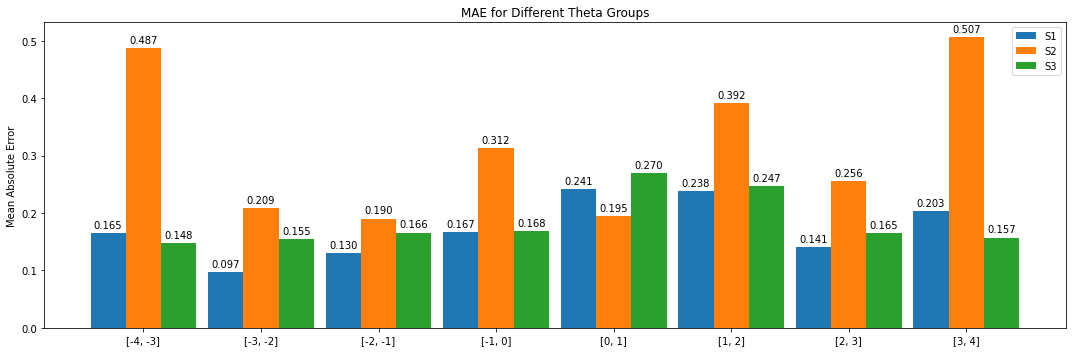

In [50]:
labels = ['[-4, -3]', '[-3, -2]', '[-2, -1]', '[-1, 0]', '[0, 1]', '[1, 2]', '[2, 3]', '[3, 4]']
s1_mae = [np.mean(abs_e[seed_list==123][(theta >= level) & (theta <= level+1)])  for level in range(-4, 4) ]
s2_mae = [np.mean(abs_e[seed_list==1234][(theta >= level) & (theta <= level+1)])  for level in range(-4, 4) ]
s3_mae = [np.mean(abs_e[seed_list==12345][(theta >= level) & (theta <= level+1)])  for level in range(-4, 4) ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(1, figsize=(15,5))
rects1 = ax.bar(x - width, s1_mae, width, label='S1')
rects2 = ax.bar(x , s2_mae, width, label='S2')
rects3 = ax.bar(x + width, s3_mae, width, label='S3')

ax.set_title('MAE for Different Theta Groups')
ax.set_ylabel('Mean Absolute Error')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, fmt='%.3f', padding=3)
ax.bar_label(rects2, fmt='%.3f', padding=3)
ax.bar_label(rects3, fmt='%.3f', padding=3)

fig.tight_layout()

### No. Questions

The data suggests that the mean question count without the edge cases are $21.58559 ± 6.45004$. To maintain the low mean absolute error in the border sections, the model has to ask up to 90 questions to converge since there was no suitable questions with the appropriate difficulty $b$ value to accomodate. 

Mean Question Count:	33.19667 ± 26.78354
Mean Question Count Without Edges:	21.58559 ± 6.45004


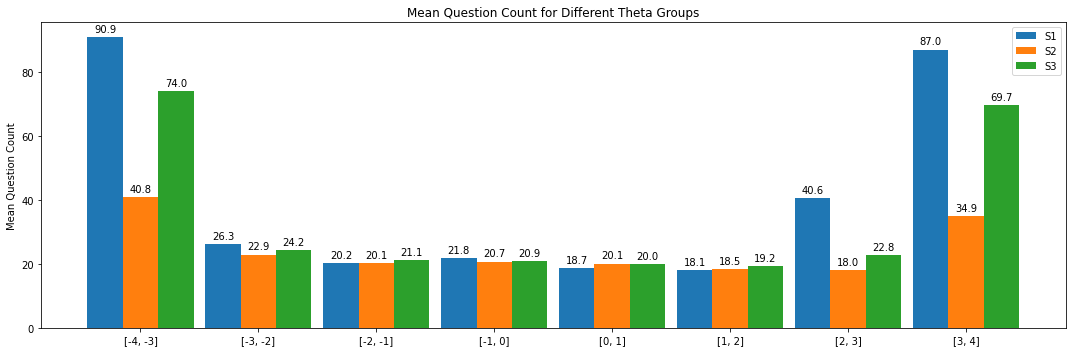

In [53]:
q_count = np.array([x["q_count"] for x in result_list])
seed_list = np.array([x["seed"] for x in result_list])
theta_real_list = np.array([x["theta_real"] for x in result_list])
q_count_mean = np.mean(q_count)
q_count_std = np.std(q_count)

print(f"Mean Question Count:\t{q_count_mean:.05f} ± {q_count_std:.05f}")
print(f"Mean Question Count Without Edges:\t{np.mean(q_count[(theta_real_list >= -3) & (theta_real_list <= 3)]):.05f} ± {np.std(q_count[(theta_real_list >= -3) & (theta_real_list <= 3)]):.05f}")

labels = ['[-4, -3]', '[-3, -2]', '[-2, -1]', '[-1, 0]', '[0, 1]', '[1, 2]', '[2, 3]', '[3, 4]']
s1_q_count = [np.mean(q_count[seed_list==123][(theta >= level) & (theta <= level+1)])  for level in range(-4, 4) ]
s2_q_count = [np.mean(q_count[seed_list==1234][(theta >= level) & (theta <= level+1)])  for level in range(-4, 4) ]
s3_q_count = [np.mean(q_count[seed_list==12345][(theta >= level) & (theta <= level+1)])  for level in range(-4, 4) ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(1, figsize=(15,5))
rects1 = ax.bar(x - width, s1_q_count, width, label='S1')
rects2 = ax.bar(x , s2_q_count, width, label='S2')
rects3 = ax.bar(x + width, s3_q_count, width, label='S3')

ax.set_title('Mean Question Count for Different Theta Groups')
ax.set_ylabel('Mean Question Count')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, fmt='%.1f', padding=3)
ax.bar_label(rects2, fmt='%.1f', padding=3)
ax.bar_label(rects3, fmt='%.1f', padding=3)

fig.tight_layout()

### Number of Iterations per Optimization Step

Mean Question Count:	6.14188 ± 12.09145


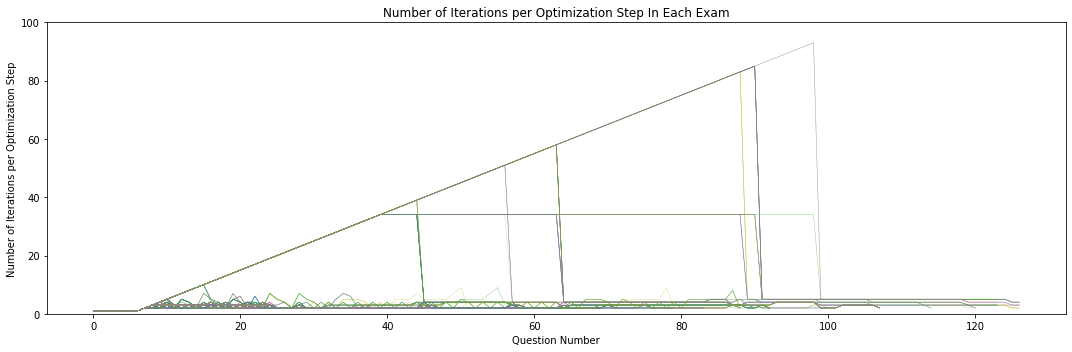

In [74]:
niter_list = [x["niter_list"] for x in result_list]
q_count = np.array([x["q_count"] for x in result_list])

niter_list_mean = np.mean(np.concatenate(niter_list))
niter_list_std = np.std(np.concatenate(niter_list))

print(f"Mean Question Count:\t{niter_list_mean:.05f} ± {niter_list_std:.05f}")

fig, ax = plt.subplots(1, figsize=(15,5))

for i, niter in enumerate(niter_list):
    x = np.arange(q_count[i])  
    ax.plot(x, niter, width, alpha=0.5, linewidth=0.5)

ax.set_title('Number of Iterations per Optimization Step In Each Exam')
ax.set_ylabel('Number of Iterations per Optimization Step')
ax.set_xlabel('Question Number')
ax.set_ylim(0,100)

fig.tight_layout()

### Theta Convergence

Mean Theta:	-0.11401 ± 2.93941


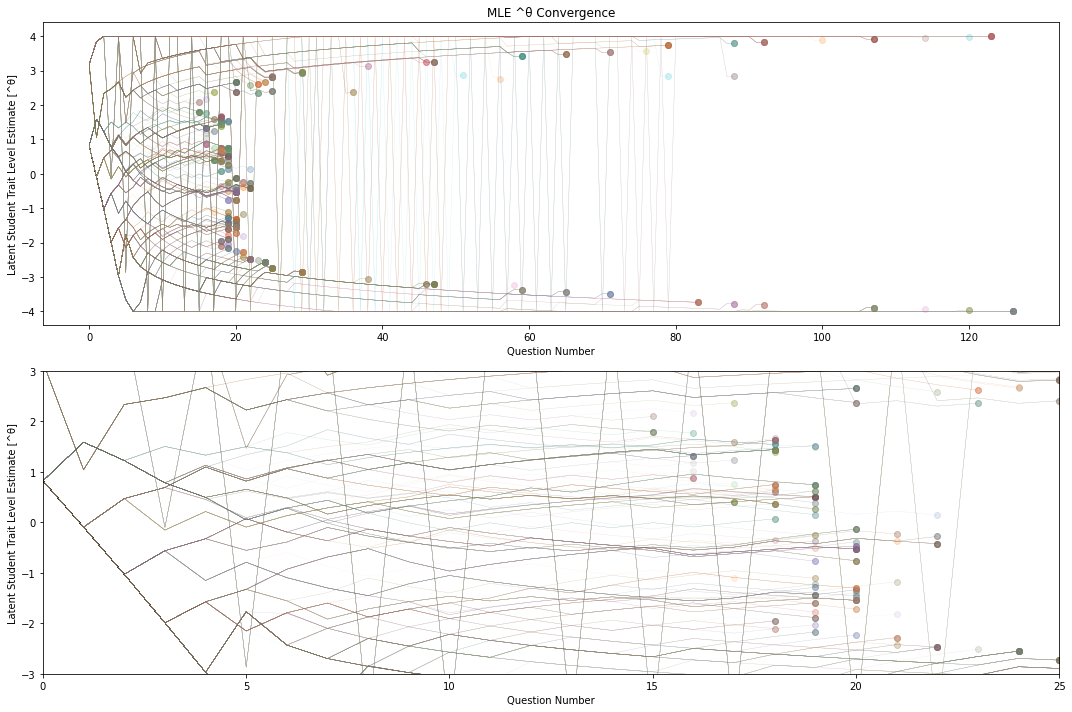

In [97]:
theta_list_list = [x["theta_list"] for x in result_list]
q_count = np.array([x["q_count"] for x in result_list])

theta_list_mean = np.mean(np.concatenate(theta_list_list))
theta_list_std = np.std(np.concatenate(theta_list_list))

print(f"Mean Theta:\t{theta_list_mean:.05f} ± {theta_list_std:.05f}")

fig, (ax1 , ax2) = plt.subplots(2, figsize=(15,10))

for i, theta_list in enumerate(theta_list_list):
    x = np.arange(q_count[i])  
    ax1.plot(x, theta_list, alpha=0.2, linewidth=0.3)# Mark end of the line
    ax1.scatter(x[-1], theta_list[-1], marker='o', alpha=0.2, linewidths=1.0, zorder=2)

ax1.set_title('MLE ^θ Convergence')
ax1.set_ylabel('Latent Student Trait Level Estimate [^θ]')
ax1.set_xlabel('Question Number')

# Zoomed Version of the same graph
for i, theta_list in enumerate(theta_list_list):
    x = np.arange(q_count[i])  
    ax2.plot(x, theta_list, '-', alpha=0.1, linewidth=0.3)
    # Mark end of the line
    ax2.scatter(x[-1], theta_list[-1], marker='o', alpha=0.1, zorder=2)

ax2.set_ylabel('Latent Student Trait Level Estimate [^θ]')
ax2.set_xlabel('Question Number')
ax2.set_xlim(0, 25)
ax2.set_ylim(-3, 3)

fig.tight_layout()

### Standard Error Convergence

Mean Standard Error:	0.56834 ± 0.30934


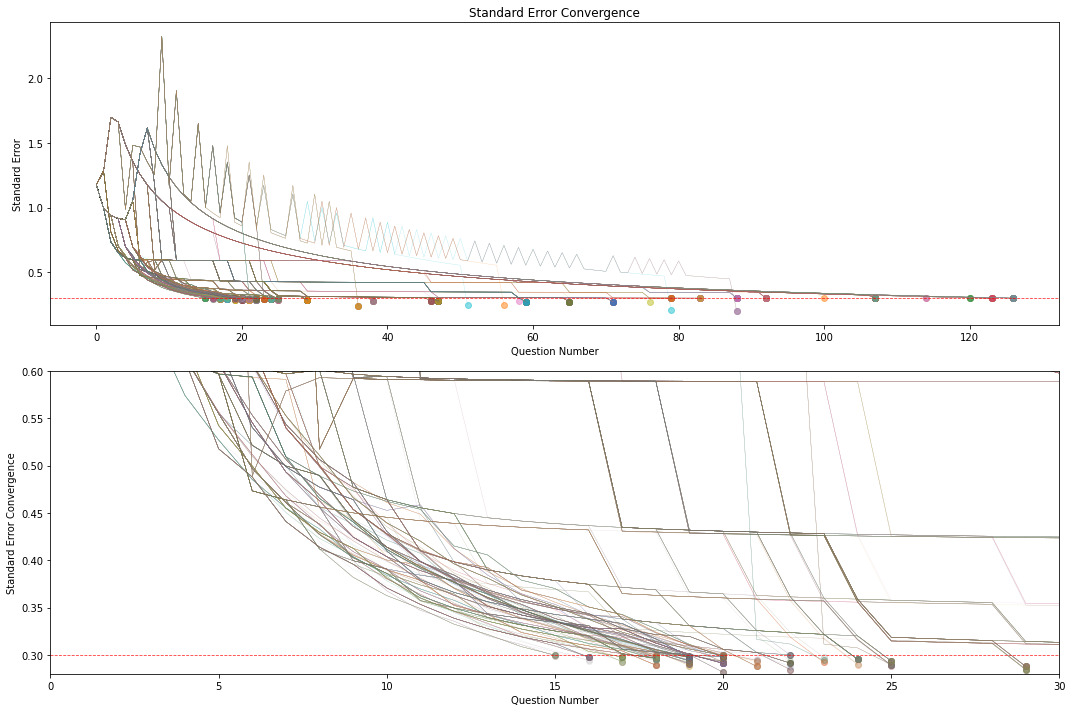

In [111]:
se_list_list = [x["se_list"] for x in result_list]
q_count = np.array([x["q_count"] for x in result_list])

se_list_mean = np.mean(np.concatenate(se_list_list))
se_list_std = np.std(np.concatenate(se_list_list))

print(f"Mean Standard Error:\t{se_list_mean:.05f} ± {se_list_std:.05f}")

fig, (ax1 , ax2) = plt.subplots(2, figsize=(15,10))

for i, se_list in enumerate(se_list_list):
    x = np.arange(q_count[i])  
    ax1.plot(x, se_list, alpha=0.4, linewidth=0.3)
    # Mark end of the line
    ax1.scatter(x[-1], se_list[-1], marker='o', alpha=0.5, linewidths=1.0, zorder=2)
ax1.axhline(y=0.3, linewidth=0.8, linestyle='--', color='r', alpha=0.8)

ax1.set_title('Standard Error Convergence')
ax1.set_ylabel('Standard Error')
ax1.set_xlabel('Question Number')

# Zoomed Version of the same graph
for i, se_list in enumerate(se_list_list):
    x = np.arange(q_count[i])  
    ax2.plot(x, se_list, '-', alpha=0.2, linewidth=0.3)
    # Mark end of the line
    ax2.scatter(x[-1], se_list[-1], marker='o', alpha=0.1, zorder=2)

ax2.axhline(y=0.3, linewidth=0.8, linestyle='--', color='r', alpha=0.8)
ax2.set_ylabel('Standard Error Convergence')
ax2.set_xlabel('Question Number')
ax2.set_xlim(0, 30)
ax2.set_ylim(0.28, 0.6)

fig.tight_layout()

## Nelder-Mead Algorithm

In [115]:
%%time

# Nelder-Mead
MIN_Q_COUNT = 15
Q_START = 5 # The number of questions before starting optimize more than 1 iter

# This should be an object of a_list, b_list, u_list, theta_list, niter_list, se_list, converge_list
# [Scalar]: theta_final, theta_real, se_final, mae, q_count, seed
result_list = []

# For all Students
for theta_real in theta:
    # For all Seeds
    for seed in [123,1234,12345]:
        rng = np.random.default_rng(seed)
        
        t = 2
        q_count = 0
        std_err = 100

        a_list = np.array([])
        b_list = np.array([])
        u_list = np.array([])
        theta_list = []
        niter_list = []
        se_list = []
        converge_list = []

        while not (q_count >= MIN_Q_COUNT and std_err <= 0.3):
            # All of the information in all the items
            items_info = fisher_information(a,b,t)
            # Find the indexes of the items with maximum information (have only 1 axis so [0])
            item_max_info_indexes = np.where(items_info==np.max(items_info))[0]
            # Select a random item from the max indexes
            item_index = rng.choice(item_max_info_indexes)

            # The question is a,b at item_index
            a_list = np.append(a_list, a[item_index])
            b_list = np.append(b_list, b[item_index])
            # Make Binomial Sampling with n=1 trial and p=probability matrix
            p = two_pl(a[item_index],b[item_index],theta_real)
            answer = rng.binomial(1, p)
            u_list = np.append(u_list, answer)
            
            to_minimize = get_log_likelihood_f(a_list, b_list, u_list)
            res = minimize(to_minimize, t, method=MINIMIZATION_METHOD, tol=1e-03, options={ "maxiter": max(q_count - Q_START, 2)})
            std_err = np.sqrt(1/np.sum(fisher_information(a_list,b_list,t)))
            t = res.x # Nelder Mead doesn't work well with bounds!!! 
    
            theta_list.extend(t) # Since t is [1]
            niter_list.append(res.nit)
            se_list.append(std_err)
            converge_list.append(res.success)
            
            q_count += 1
        
        result_list.append({
            "a_list": a_list,
            "b_list": b_list,
            "u_list": u_list,
            "theta_list": theta_list,
            "niter_list": niter_list,
            "se_list": se_list,
            "converge_list": converge_list,
            "theta_final": t[0],
            "theta_real": theta_real,
            "se_final": std_err,
            "mae": np.abs(t - theta_real),
            "q_count": q_count,
            "seed": seed
        })

/tmp/ipykernel_428/1742882046.py:16: RuntimeWarning: divide by zero encountered in log
  return np.sum(u*np.log(p) + (1-u)*np.log(1-p))*is_minimize
/tmp/ipykernel_428/1742882046.py:16: RuntimeWarning: invalid value encountered in multiply
  return np.sum(u*np.log(p) + (1-u)*np.log(1-p))*is_minimize


CPU times: user 1min 28s, sys: 59.2 ms, total: 1min 28s
Wall time: 1min 28s


### Mean Absolute Error

We can observe that the mean absolute error is quite the same with Newton-Rhapson $0.23663 ± 0.16402$. However, the edge cases were not as severe but there is a compromise in the middle ranges of $\theta$, where the results were really varied between seeds. Some jump to MAE of more than 0.3 or 0.4, which is not the case with Newton-Rhapson.

In [116]:
abs_e = np.array([x["mae"] for x in result_list])
seed_list = np.array([x["seed"] for x in result_list])
mae = np.mean(abs_e)
mae_std = np.std(abs_e)

print(f"Mean Absolute Error:\t{mae:.05f} ± {mae_std:.05f}")

print("MAE Per Category")
for seed in [123,1234,12345]:
    print(f"Seed: {seed}")
    abs_e_s = abs_e[seed_list==seed]
    # Draw Section lines for student ability 
    for level in range(-4, 4):
        _abs_e = abs_e_s[(theta >= level) & (theta <= level+1)]
        _mae = np.mean(_abs_e)
        _mae_std = np.std(_abs_e)
        print(f"θ [{level}, {level+1}]:\t{_mae:.05f} ± {_mae_std:.05f}")

Mean Absolute Error:	0.23663 ± 0.16402
MAE Per Category
Seed: 123
θ [-4, -3]:	0.15833 ± 0.05853
θ [-3, -2]:	0.13765 ± 0.07389
θ [-2, -1]:	0.19176 ± 0.09461
θ [-1, 0]:	0.13389 ± 0.10692
θ [0, 1]:	0.14282 ± 0.11597
θ [1, 2]:	0.16982 ± 0.11399
θ [2, 3]:	0.19770 ± 0.09326
θ [3, 4]:	0.22027 ± 0.04998
Seed: 1234
θ [-4, -3]:	0.23696 ± 0.13346
θ [-3, -2]:	0.27027 ± 0.13265
θ [-2, -1]:	0.36419 ± 0.24621
θ [-1, 0]:	0.13893 ± 0.08945
θ [0, 1]:	0.35553 ± 0.28570
θ [1, 2]:	0.33733 ± 0.11419
θ [2, 3]:	0.22333 ± 0.10912
θ [3, 4]:	0.49060 ± 0.11510
Seed: 12345
θ [-4, -3]:	0.12487 ± 0.10457
θ [-3, -2]:	0.25155 ± 0.11837
θ [-2, -1]:	0.44073 ± 0.12358
θ [-1, 0]:	0.32371 ± 0.15536
θ [0, 1]:	0.15368 ± 0.08010
θ [1, 2]:	0.23336 ± 0.13334
θ [2, 3]:	0.21116 ± 0.11824
θ [3, 4]:	0.16291 ± 0.09140


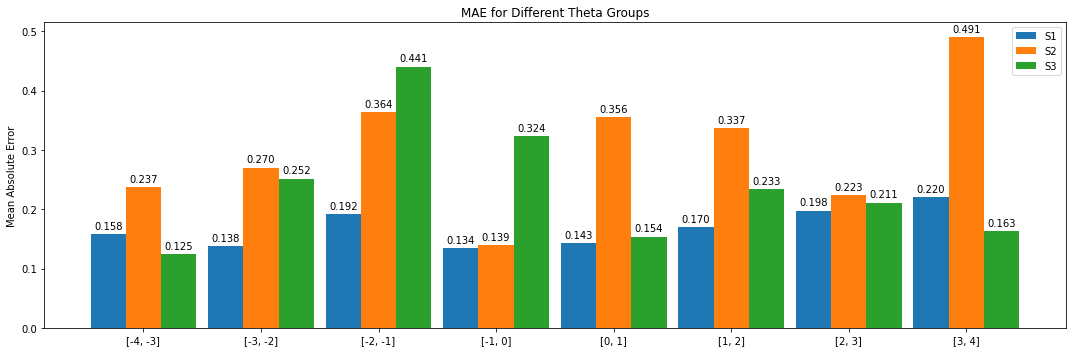

In [117]:
labels = ['[-4, -3]', '[-3, -2]', '[-2, -1]', '[-1, 0]', '[0, 1]', '[1, 2]', '[2, 3]', '[3, 4]']
s1_mae = [np.mean(abs_e[seed_list==123][(theta >= level) & (theta <= level+1)])  for level in range(-4, 4) ]
s2_mae = [np.mean(abs_e[seed_list==1234][(theta >= level) & (theta <= level+1)])  for level in range(-4, 4) ]
s3_mae = [np.mean(abs_e[seed_list==12345][(theta >= level) & (theta <= level+1)])  for level in range(-4, 4) ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(1, figsize=(15,5))
rects1 = ax.bar(x - width, s1_mae, width, label='S1')
rects2 = ax.bar(x , s2_mae, width, label='S2')
rects3 = ax.bar(x + width, s3_mae, width, label='S3')

ax.set_title('MAE for Different Theta Groups')
ax.set_ylabel('Mean Absolute Error')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, fmt='%.3f', padding=3)
ax.bar_label(rects2, fmt='%.3f', padding=3)
ax.bar_label(rects3, fmt='%.3f', padding=3)

fig.tight_layout()

### No. Questions

The data suggests that the mean question count without the edge cases are $24.84985 ± 6.12372$, which is 3 more questions than the Newton-Rhapson.

Mean Question Count:	37.91889 ± 29.15489
Mean Question Count Without Edges:	24.84985 ± 6.12372


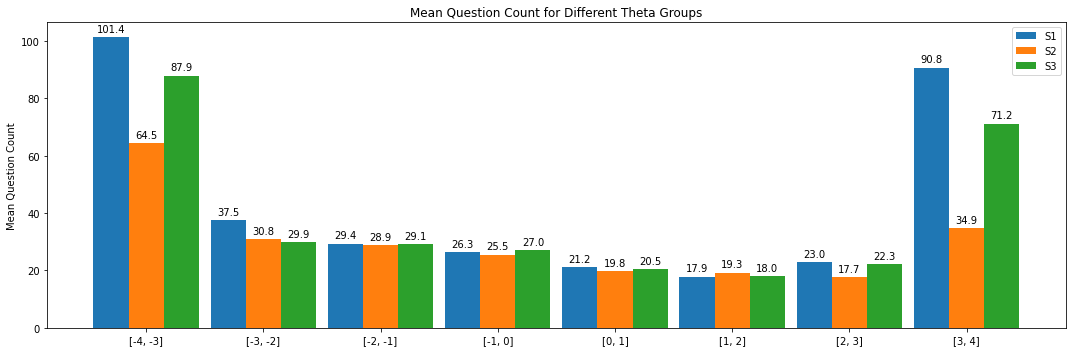

In [118]:
q_count = np.array([x["q_count"] for x in result_list])
seed_list = np.array([x["seed"] for x in result_list])
theta_real_list = np.array([x["theta_real"] for x in result_list])
q_count_mean = np.mean(q_count)
q_count_std = np.std(q_count)

print(f"Mean Question Count:\t{q_count_mean:.05f} ± {q_count_std:.05f}")
print(f"Mean Question Count Without Edges:\t{np.mean(q_count[(theta_real_list >= -3) & (theta_real_list <= 3)]):.05f} ± {np.std(q_count[(theta_real_list >= -3) & (theta_real_list <= 3)]):.05f}")

labels = ['[-4, -3]', '[-3, -2]', '[-2, -1]', '[-1, 0]', '[0, 1]', '[1, 2]', '[2, 3]', '[3, 4]']
s1_q_count = [np.mean(q_count[seed_list==123][(theta >= level) & (theta <= level+1)])  for level in range(-4, 4) ]
s2_q_count = [np.mean(q_count[seed_list==1234][(theta >= level) & (theta <= level+1)])  for level in range(-4, 4) ]
s3_q_count = [np.mean(q_count[seed_list==12345][(theta >= level) & (theta <= level+1)])  for level in range(-4, 4) ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(1, figsize=(15,5))
rects1 = ax.bar(x - width, s1_q_count, width, label='S1')
rects2 = ax.bar(x , s2_q_count, width, label='S2')
rects3 = ax.bar(x + width, s3_q_count, width, label='S3')

ax.set_title('Mean Question Count for Different Theta Groups')
ax.set_ylabel('Mean Question Count')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, fmt='%.1f', padding=3)
ax.bar_label(rects2, fmt='%.1f', padding=3)
ax.bar_label(rects3, fmt='%.1f', padding=3)

fig.tight_layout()

### Number of Iterations per Optimization Step

Mean Question Count:	7.37976 ± 3.40632


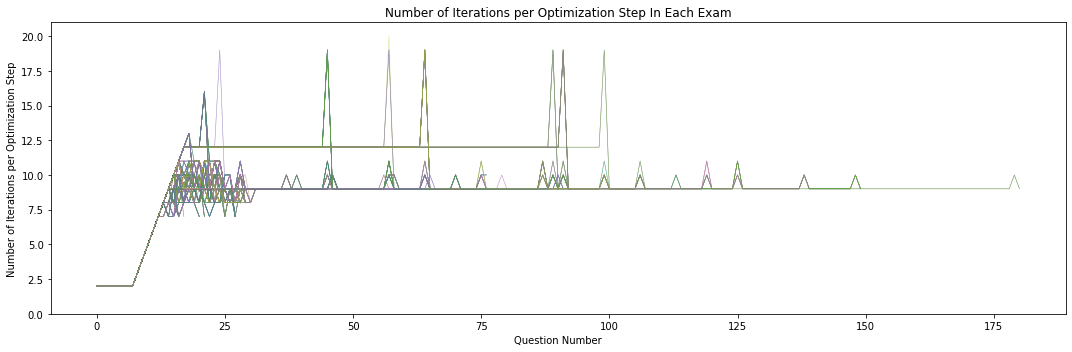

In [122]:
niter_list = [x["niter_list"] for x in result_list]
q_count = np.array([x["q_count"] for x in result_list])

niter_list_mean = np.mean(np.concatenate(niter_list))
niter_list_std = np.std(np.concatenate(niter_list))

print(f"Mean Question Count:\t{niter_list_mean:.05f} ± {niter_list_std:.05f}")

fig, ax = plt.subplots(1, figsize=(15,5))

for i, niter in enumerate(niter_list):
    x = np.arange(q_count[i])  
    ax.plot(x, niter, width, alpha=0.5, linewidth=0.5)

ax.set_title('Number of Iterations per Optimization Step In Each Exam')
ax.set_ylabel('Number of Iterations per Optimization Step')
ax.set_xlabel('Question Number')
ax.set_ylim(0)

fig.tight_layout()

### Theta Convergence

Since Nelder-Mead doesn't work well with Bounds and clipping, the theta is able to swing to as high as $\pm 20$. However, it seems to be able to converge in the middle although using more questions and with higher MAE.

Mean Theta:	-1.28659 ± 10.38560


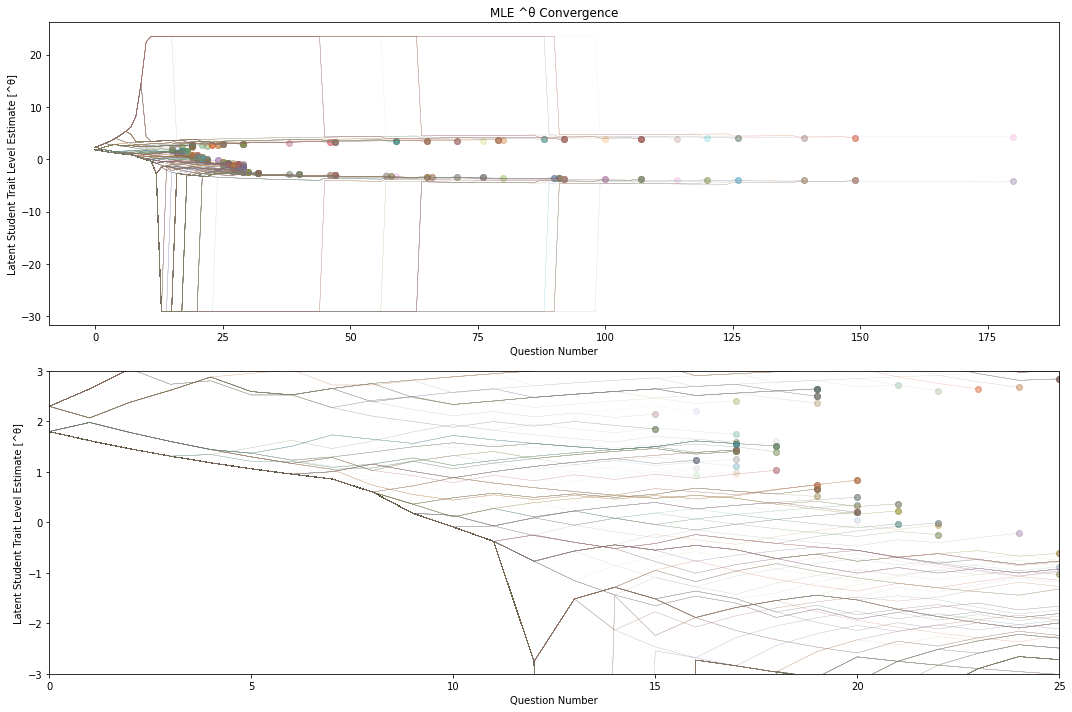

In [120]:
theta_list_list = [x["theta_list"] for x in result_list]
q_count = np.array([x["q_count"] for x in result_list])

theta_list_mean = np.mean(np.concatenate(theta_list_list))
theta_list_std = np.std(np.concatenate(theta_list_list))

print(f"Mean Theta:\t{theta_list_mean:.05f} ± {theta_list_std:.05f}")

fig, (ax1 , ax2) = plt.subplots(2, figsize=(15,10))

for i, theta_list in enumerate(theta_list_list):
    x = np.arange(q_count[i])  
    ax1.plot(x, theta_list, alpha=0.2, linewidth=0.3)# Mark end of the line
    ax1.scatter(x[-1], theta_list[-1], marker='o', alpha=0.2, linewidths=1.0, zorder=2)

ax1.set_title('MLE ^θ Convergence')
ax1.set_ylabel('Latent Student Trait Level Estimate [^θ]')
ax1.set_xlabel('Question Number')

# Zoomed Version of the same graph
for i, theta_list in enumerate(theta_list_list):
    x = np.arange(q_count[i])  
    ax2.plot(x, theta_list, '-', alpha=0.1, linewidth=0.3)
    # Mark end of the line
    ax2.scatter(x[-1], theta_list[-1], marker='o', alpha=0.1, zorder=2)

ax2.set_ylabel('Latent Student Trait Level Estimate [^θ]')
ax2.set_xlabel('Question Number')
ax2.set_xlim(0, 25)
ax2.set_ylim(-3, 3)

fig.tight_layout()

### Standard Error Convergence

Mean Standard Error:	159426949.47991 ± 593141437.02861


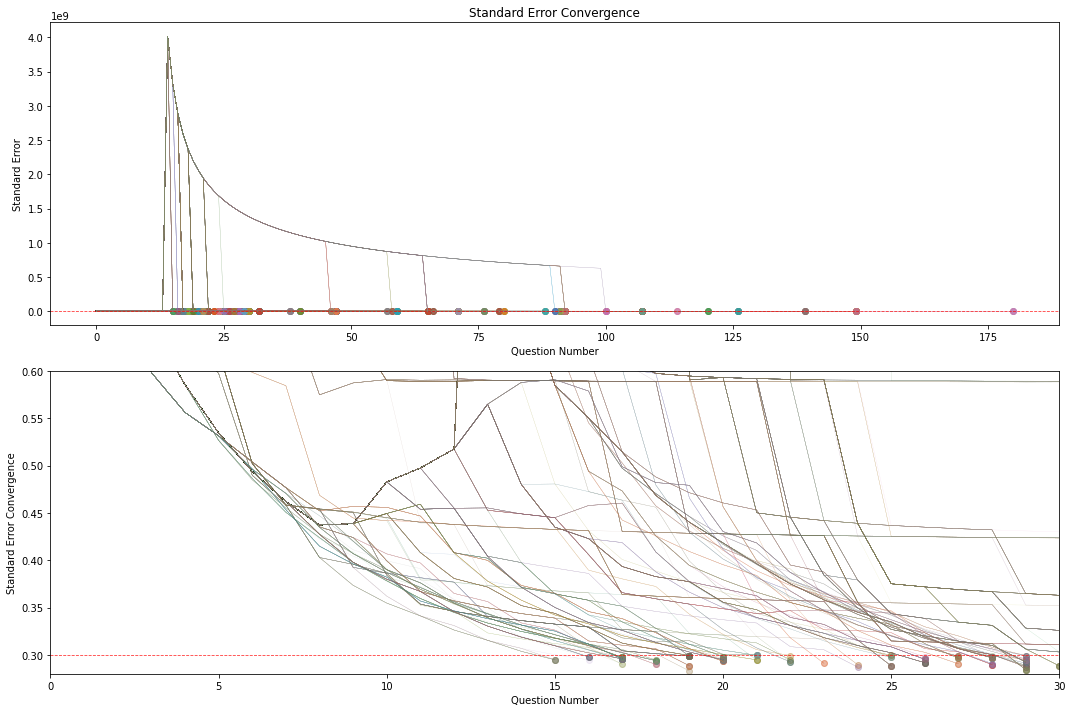

In [121]:
se_list_list = [x["se_list"] for x in result_list]
q_count = np.array([x["q_count"] for x in result_list])

se_list_mean = np.mean(np.concatenate(se_list_list))
se_list_std = np.std(np.concatenate(se_list_list))

print(f"Mean Standard Error:\t{se_list_mean:.05f} ± {se_list_std:.05f}")

fig, (ax1 , ax2) = plt.subplots(2, figsize=(15,10))

for i, se_list in enumerate(se_list_list):
    x = np.arange(q_count[i])  
    ax1.plot(x, se_list, alpha=0.4, linewidth=0.3)
    # Mark end of the line
    ax1.scatter(x[-1], se_list[-1], marker='o', alpha=0.5, linewidths=1.0, zorder=2)
ax1.axhline(y=0.3, linewidth=0.8, linestyle='--', color='r', alpha=0.8)

ax1.set_title('Standard Error Convergence')
ax1.set_ylabel('Standard Error')
ax1.set_xlabel('Question Number')

# Zoomed Version of the same graph
for i, se_list in enumerate(se_list_list):
    x = np.arange(q_count[i])  
    ax2.plot(x, se_list, '-', alpha=0.2, linewidth=0.3)
    # Mark end of the line
    ax2.scatter(x[-1], se_list[-1], marker='o', alpha=0.1, zorder=2)

ax2.axhline(y=0.3, linewidth=0.8, linestyle='--', color='r', alpha=0.8)
ax2.set_ylabel('Standard Error Convergence')
ax2.set_xlabel('Question Number')
ax2.set_xlim(0, 30)
ax2.set_ylim(0.28, 0.6)

fig.tight_layout()

# AWS Implementation

To implement this, I will create a Lambda Function where it requires several arguments and will need to be triggered for each answer.

1. `/exam/begin` -> Start of the Exam. Generate `examId` along with starting of the timer. Use `initialTheta` that may come from the training sessions/average of class/2 or 3. Select a question from item pool and return that item. 
    - Input: subject-grade-chapter-lesson, userId
    - Output: examId, timeLeft, question {questionId, a, b}
2. `/exam/answer` -> Answer a single question in the exam. Log answer and get correctness {u}. Check termination criteria (timeout, question count > 15, standard error < 0.3). If not, Select a question from item pool and return the next question. If true, end the exam.
    - Input: examId, answer
    - Output: isEnd: true/false, endReason: TIMEOUT/CONVERGE, timeLeft, correct {u}, question {questionId, a, b}

# Gradient Descent vs. Newton Rhapsodian
https://www.baeldung.com/cs/gradient-descent-vs-newtons-gradient-descent

https://stats.stackexchange.com/questions/376191/why-is-the-second-derivative-required-for-newtons-method-for-back-propagation

$$\theta_{n+1} = \theta_n - \alpha f'(\theta_n)$$

$$\theta_{n+1} = \theta_n +  \frac{ f'(\theta_n) }{ f''(\theta_n) }$$

# Item Response Theory

https://en.wikipedia.org/wiki/Item_response_theory

![](https://upload.wikimedia.org/wikipedia/commons/7/7b/3PL_IRF.png)

# Python Related Libraries

- [douglasrizzo/catsim](https://github.com/douglasrizzo/catsim) [Watch 7, Star 72, Fork 25]  
catsim is a Python package for computerized adaptive testing (CAT) simulations. It provides multiple methods for: test initialization (selecting the initial ability of the examinees), item selection, ability estimation, test stopping
- [eribean/girth](https://github.com/eribean/girth) [Watch 2, Star 17, Fork 3]  
Georgia Tech Item Response Theory (Girth) is a python package for estimating item response theory (IRT) parameters. In addition, synthetic IRT data generation is supported. Below is a list of available functions, for more information visit the GIRTH homepage.

IRT response data should be stored in a 2D numpy array. This array holds the measured responses with the number of rows (vertical) equal to the number of items in the test, and the number of columns (horizontal) equal to the number of participants in the test.

<img src="https://eribean.github.io/girth/images/girth_data.jpg" alt="girth data" width="400"/>

- [17zuoye/pyirt](https://github.com/17zuoye/pyirt) [Watch 18, Star 82, Fork 47]  
A python library of IRT algorithm designed to cope with sparse data structure.
[Model Specification](https://github.com/17zuoye/pyirt/wiki/Model-Specification)
The current version supports MMLE algorithm and unidimension two parameter IRT model.
The package offers two methods to estimate theta, given item parameters: Bayesian and MLE.
The theta paramter range from [-4,4] and a step size of 0.8 by default.
Alpha is bounded by [0.25,2] and beta is bounded by [-2,2]
- [pluralsight/irt_parameter_estimation](https://github.com/pluralsight/irt_parameter_estimation) [Watch 9, Star 34, Fork 20]  
This package implements parameter estimation for logistic Item Characteristic Curves (ICC) from Item Response Theory (IRT).
Many of the methods in this package are derived from work by Frank B. Baker and Seock-Ho Kim: Item Response Theory: Parameter Estimation Techniques. [QuickTutorial.ipynb](https://github.com/pluralsight/irt_parameter_estimation/blob/master/doc/QuickTutorial.ipynb)
- [aimir/irt](https://github.com/aimir/irt) [Watch 2, Star 20, Fork 3]  
Item Response Theory in Python. The parameter estimation is done using MMLE with parameter regulation, and the underlying optimization uses scipy.optimize. Rather simplistic code, good for using.
- [nd-ball/py-irt](https://github.com/nd-ball/py-irt) [Watch 3, Star 25, Fork 12]  
Bayesian IRT models in Python.

Not Used:  
- [mhw32/variational-item-response-theory-public](https://github.com/mhw32/variational-item-response-theory-public) [Watch 4, Star 40, Fork 10]  
A PyTorch implementation of "Variational Item Response Theory: Fast Accurate, and Expressive". 
Looks like a good implementation but we're not going to use this, since the model is different. 
- [philchalmers/mirt](https://github.com/philchalmers/mirt) [Watch 32, Star 149, Fork 68]  
Multidimensional item response theory. 
Looks like a popular library, but written in R. Will come back if nothing to look at.